In [2]:
# Load dataset
import seaborn as sns

df = sns.load_dataset("titanic")

X = df.drop('alive', axis=1)
y = df['alive']

In [3]:
# EDA

print('5 Data teratas\n',df.head(),'\n')

print('isi dataset\n',df.describe(),'\n')

print('Cek Missing values\n',df.isnull().sum(),'\n')

5 Data teratas
    survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True   

isi dataset
          survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   

In [4]:
# Handle missing values

# age
df['age'] = df['age'].fillna(df['age'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
df['embark_town'] = df['embark_town'].fillna(df['embark_town'].mode()[0])
if 'deck' in df.columns: # Pastikan kolom deck ada sebelum di drop
    df.drop('deck', axis=1, inplace=True)

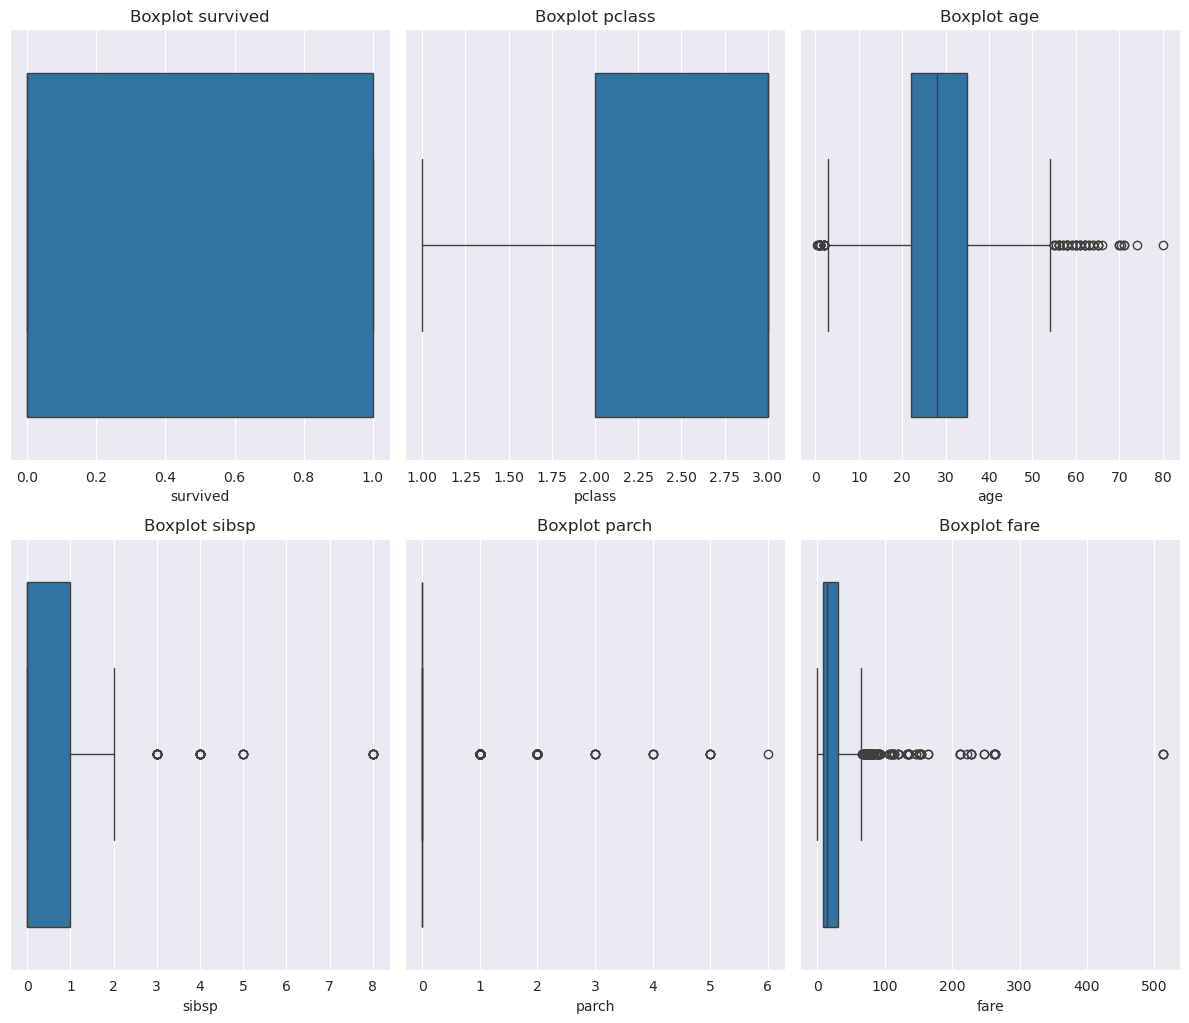

In [5]:
# Cek outlier
import seaborn as sns
import matplotlib.pyplot as plt

# ambil semua kolom numerik otomatis
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
rows = len(numeric_cols) // 3 + 1  # Bagi jadi beberapa baris
cols = 3  # Misalnya 3 kolom biar rapi

plt.figure(figsize=(cols * 4, rows * 5))

for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols, i + 1)  # Atur jumlah baris dan kolom
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')

plt.tight_layout()
plt.show()

In [6]:
# Handle outlier

# Log Transformation untuk Kolom fare
import numpy as np

# Anggap df adalah DataFrame kamu yang sudah di-handle missing values-nya
# Pastikan kolom 'fare' ada di df kamu

print("Distribusi 'fare' sebelum log transformation:")
print(df['fare'].describe()) # Lihat statistiknya biar tahu distribusinya

# Terapkan log transformation ke kolom 'fare'
df['fare'] = np.log1p(df['fare'])

print("\nDistribusi 'fare' setelah log transformation:")
print(df['fare'].describe()) # Lihat lagi, harusnya udah lebih 'normal' sekarang

Distribusi 'fare' sebelum log transformation:
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64

Distribusi 'fare' setelah log transformation:
count    891.000000
mean       2.962246
std        0.969048
min        0.000000
25%        2.187218
50%        2.737881
75%        3.465736
max        6.240917
Name: fare, dtype: float64


In [7]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# --- Step 3: Feature Engineering ---
df['FamilySize'] = df['sibsp'] + df['parch'] + 1
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

# Drop kolom original yang digantikan atau tidak relevan
if 'sibsp' in df.columns: df = df.drop('sibsp', axis=1)
if 'parch' in df.columns: df = df.drop('parch', axis=1)
if 'name' in df.columns: df = df.drop('name', axis=1)
if 'ticket' in df.columns: df = df.drop('ticket', axis=1) # Ticket juga sering di-drop
if 'cabin' in df.columns: df = df.drop('cabin', axis=1) # Cabin juga sering di-drop
if 'passengerid' in df.columns: df = df.drop('passengerid', axis=1)


# --- Step 4: Encoding Kolom Kategorikal (INI FOKUS UTAMA KITA SEKARANG) ---

# Identifikasi semua kolom yang tersisa dengan dtype 'object' atau 'category'
# INI YANG KRUSIAL UNTUK MENANGKAP 'class' DAN SEJENISNYA
categorical_cols_to_onehot = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Kolom yang akan di-One-Hot Encode setelah filter: {categorical_cols_to_onehot}")

# Lakukan One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols_to_onehot, drop_first=True, dtype=int)

print("\nInfo DataFrame setelah One-Hot Encoding (pastikan TIDAK ADA 'object' atau 'category'):")
df.info()
print("\n5 baris teratas DataFrame setelah One-Hot Encoding:")
print(df.head())

# --- Step 5: Split Data ---
X = df.drop('alive_yes', axis=1)
y = df['alive_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 6: Feature Scaling ---
# Identifikasi kolom numerik yang perlu discale (age, fare, FamilySize)
# Kolom hasil One-Hot Encoding (0 atau 1) tidak perlu discale
numeric_features_for_scaling = [col for col in X_train.columns if col in ['age', 'fare', 'FamilySize'] ]

# Filter kolom numerik yang benar-benar ada di X_train
# (penting karena setelah get_dummies, X_train bisa punya banyak kolom baru)
available_numeric_features_train = [col for col in numeric_features_for_scaling if col in X_train.columns]
available_numeric_features_test = [col for col in numeric_features_for_scaling if col in X_test.columns] # Pastikan sama dengan train

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Lakukan scaling pada subset kolom numerik di X_train
X_train_scaled_values = scaler.fit_transform(X_train[available_numeric_features_train])
X_test_scaled_values = scaler.transform(X_test[available_numeric_features_test])

# --- Menggabungkan kembali data setelah scaling ---
X_train_scaled_df = pd.DataFrame(X_train_scaled_values, columns=available_numeric_features_train, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled_values, columns=available_numeric_features_test, index=X_test.index)

X_train_processed = X_train.drop(columns=available_numeric_features_train)
X_test_processed = X_test.drop(columns=available_numeric_features_test)

X_train_final = pd.concat([X_train_processed, X_train_scaled_df], axis=1)
X_test_final = pd.concat([X_test_processed, X_test_scaled_df], axis=1)


print("\n--- Final Check Setelah Semua Preprocessing ---")
print("Bentuk X_train_final:", X_train_final.shape)
print("Bentuk X_test_final:", X_test_final.shape)
print("Dtypes X_train_final (harus numerik semua, penting!):")
print(X_train_final.dtypes) # Ini yang paling penting, pastikan tidak ada object
print("\n5 baris teratas X_train_final:")
print(X_train_final.head())

Kolom yang akan di-One-Hot Encode setelah filter: ['sex', 'embarked', 'class', 'who', 'embark_town', 'alive']

Info DataFrame setelah One-Hot Encoding (pastikan TIDAK ADA 'object' atau 'category'):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 891 non-null    int64  
 1   pclass                   891 non-null    int64  
 2   age                      891 non-null    float64
 3   fare                     891 non-null    float64
 4   adult_male               891 non-null    bool   
 5   alone                    891 non-null    bool   
 6   FamilySize               891 non-null    int64  
 7   IsAlone                  891 non-null    int64  
 8   sex_male                 891 non-null    int64  
 9   embarked_Q               891 non-null    int64  
 10  embarked_S               891 non-null    int

In [8]:
# Training mode
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Training
model = KNeighborsRegressor(n_neighbors=5)

# fitting
model.fit(X_train_final, y_train)

# prediksi
y_pred = model.predict(X_test_final)

# evaluasi
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred):.4f}')

MSE: 0.04893854748603352
MAE: 0.08379888268156425
R2: 0.7982


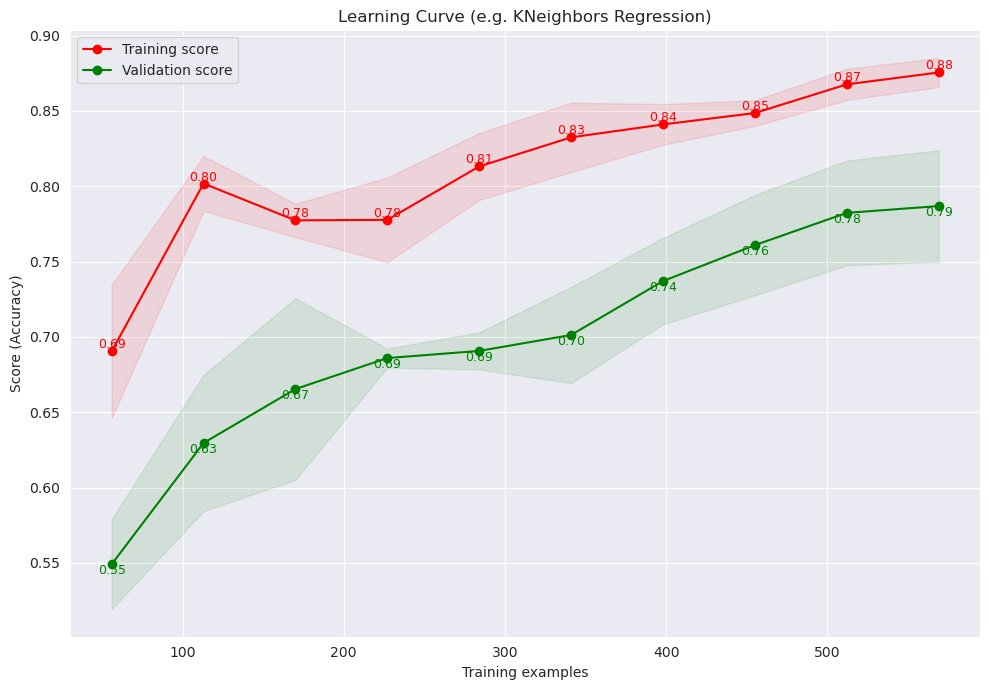

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_final, y_train,
    cv=5,
    scoring='r2',  # GANTI kalau ini buat klasifikasi
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")

# Tambahin label angka di titik kurva
for x, y in zip(train_sizes, train_scores_mean):
    plt.text(x, y, f"{y:.2f}", color='r', fontsize=9, ha='center', va='bottom')
for x, y in zip(train_sizes, test_scores_mean):
    plt.text(x, y, f"{y:.2f}", color='g', fontsize=9, ha='center', va='top')

# Setup axis dan tampilan
plt.title("Learning Curve (e.g. KNeighbors Regression)")
plt.xlabel("Training examples")
plt.ylabel("Score (Accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


# Because of Overfitting so we continue to the hyperparameter tuning (GridSearchCV)

In [10]:
print(np.isnan(X_train_final).sum())
print(np.isinf(X_train_final).sum())


survived                   0
pclass                     0
adult_male                 0
alone                      0
IsAlone                    0
sex_male                   0
embarked_Q                 0
embarked_S                 0
class_Second               0
class_Third                0
who_man                    0
who_woman                  0
embark_town_Queenstown     0
embark_town_Southampton    0
age                        0
fare                       0
FamilySize                 0
dtype: int64
survived                   0
pclass                     0
adult_male                 0
alone                      0
IsAlone                    0
sex_male                   0
embarked_Q                 0
embarked_S                 0
class_Second               0
class_Third                0
who_man                    0
who_woman                  0
embark_town_Queenstown     0
embark_town_Southampton    0
age                        0
fare                       0
FamilySize                 0
d

In [11]:
# GridsearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_grid = KNeighborsRegressor()

param_grid = {
        'n_neighbors': np.arange(5, 101, 5),
        'weights': ['uniform', 'distance'],
        'metric': ['manhattan', 'euclidean', 'minkowski'],
        'p': [1, 2, 3],
        'leaf_size': [1, 3, 5],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
)

grid_search.fit(X_train_final, y_train)

# Get best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best cross-validation score: 0.8796946381527169


/home/formylife/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:

# gunakan model terbaik
best_model = grid_search.best_estimator_

# prediksi model
y_pred_best = best_model.predict(X_test_final)

# evaluasi model
print(f'MSE: {mean_squared_error(y_test, y_pred_best)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_best)}')
print(f'R2: {r2_score(y_test, y_pred_best):.4f}')

# learning curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_final, y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")

# Tambahin label angka di titik kurva
for x, y in zip(train_sizes, train_scores_mean):
    plt.text(x, y, f"{y:.2f}", color='r', fontsize=9, ha='center', va='bottom')
for x, y in zip(train_sizes, test_scores_mean):
    plt.text(x, y, f"{y:.2f}", color='g', fontsize=9, ha='center', va='top')

# Setup axis dan tampilan
plt.title("Learning Curve (KNeighborsRegressor)") # <--- Ganti judul biar akurat!
plt.xlabel("Training examples")
plt.ylabel("Score (R2)") # <--- Ganti label sumbu Y biar sesuai metrik!
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#